# Tutorial for fitting sinusoidal nonhomogeneous Poisson processes (NHPPs)

This tutorial demonstrates how to fit to data the sinusoidal NHPP model with arrival rate
\begin{equation}\tag{1}
\lambda(t)=c_{0}+\sum_{k=1}^{p}c_{k}\cos(2\pi\nu_{k}t+\phi_{k})
\end{equation}
from Chen et al. (2023). The frequencies $\nu_1,\cdots,\nu_p$ can take on any values in a pre-specified band $(0,B]$, and $\phi_k \in [0,2\pi)$ and $c_k$ are respectively the phase and amplitude of the $k$-th sinusoid. The number of sinusoids $p$ will be estimated from data.

The details of the estimation procedure is described in Appendix A of Chen et al. (2023). In turn, the procedure is a simpler variant of the one proposed in Chen, Lee, and Negahban (2019).

#### Suggested citations
- Chen, Gurlek, Lee, Shen (2023): [Can customer arrival rates be modelled by sine waves?](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3125120) (Joint issue in *Service Science* and *Stochastic Systems*, forthcoming)

- Chen, Lee, Negahban (2019): [Super-resolution estimation of cyclic arrival rates](https://projecteuclid.org/journals/annals-of-statistics/volume-47/issue-3/Super-resolution-estimation-of-cyclic-arrival-rates/10.1214/18-AOS1736.full) (*Annals of Statistics*  47:3:1754-1775)

In [1]:
import pandas as pd
import numpy as np
import help_funcs
import matplotlib.pyplot as plt

Read in a simulated arrivals dataset consisting of arrival timestamps over the course of 365 days ($T=365$). The data is generated according to the NHPP model in Section 3 of the paper, with $\alpha = 3$. To keep this illustrative dataset to a reasonable size, we scaled down the arrival rate used in the paper by a factor of 10 in order to reduce the number of simulated arrivals.

In [2]:
arrivals = pd.read_csv('simulated_arrivals.csv')
arrivals.head()

,arrival_time_in_days
0,0.002607
1,0.003344
2,0.003906
3,0.005658
4,0.008437


Use the `center_periodogram()` function from the `help_funcs` module to identify the frequencies $\nu_1,\cdots,\nu_p$ in the arrivals data. This corresponds to equation (12) and Figure 4 in Appendix A of Chen et al. (2023).


The `center_periodogram()` function accepts the following arguments:
- `T`: Length of the observation window ($T=365$ days in the example)
- `obs`: The vector of arrival timestamps as a $1\times N$ numpy array
- `a`: Average arrival rate, `N`/`T`
- `freq_grid`: The grid of frequencies used to sample the periodogram. The grid spacing needs to be finer than $O(1/T)$. In this example we use a resolution of $1/(T\log T)$

In [3]:
obs = arrivals.arrival_time_in_days.values.reshape((1, -1))
T = 365
a = obs.size / T

max_freq = 6 #in this example, this means a maximum frequency of B=6 cycles per day
freq_resolution = T*np.log(T)
freq_grid = np.linspace( 0, max_freq, num=int( max_freq*freq_resolution ) ).reshape((1, -1))

The periodogram may take some time to run, especially for large datasets.

In [4]:
windowed_periodogram = help_funcs.center_periodogram(T, obs, freq_grid, a)

Graph the periodogram to visualize the frequencies present in the arrivals data, and their amplitudes.

Text(0, 0.5, 'Amplitude')

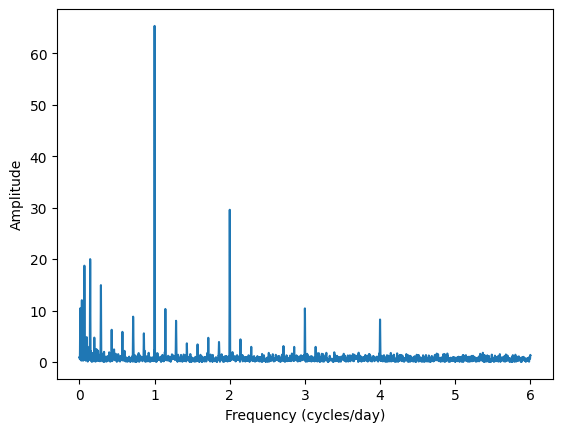

In [5]:
plt.plot(freq_grid.flatten(), windowed_periodogram.flatten())

plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")

Ignore frequencies with amplitudes below a certain noise threshold $\tau$. This represents the level of statistical noise in the frequency domain. The threshold $\tau$ can often be visually inspected. In the example above we pick $\tau = 6$.

The set of frequencies with amplitudes larger than $\tau$ is further reduced so that there are no frequencies within $4/T$ of one another (Step 4 in Algorithm A.1 of Chen et al. (2023)). The amplitudes $c_k$'s and phases $\phi_k$'s for the remaining frequencies are then fit by complex-valued least squares. The `lse_time_cont()` function from the `help_funcs` module accomplishes these tasks.

In [6]:
tau = 6 #determined by visual inspection of the periodogram above

constant, fitted_params = help_funcs.lse_time_cont(
    obs, windowed_periodogram, freq_grid, tau, T
)

The estimated constant ($c_0$) is:

In [7]:
print(constant)

[499.47365932]


The other estimated parameters are given in the table below:
- `freq`: The frequencies $\nu_k$'s (in this example, cycles per day)
- `amplitude`: The amplitudes $c_k$'s (arrivals per day in this example)
-  `phase`: The phases $\phi_k$'s

In [8]:
fitted_params.index = fitted_params.index + 1
fitted_params

,freq,amplitude,phase
1,0.428671,25.188744,2.561518
2,0.043192,26.401593,-1.489375
3,1.285548,32.063521,-0.199238
4,3.999690,31.074860,-3.113582
5,0.714297,33.282714,0.519425
6,1.142968,40.924155,-0.438199
7,2.999768,42.331432,-0.798639
8,0.010682,42.733883,-0.228305
9,0.032046,45.467567,0.382237
10,0.285626,61.313541,2.970336


Now that we have the parameter estimates, plot the estimated arrival rate $(1)$ over the first 14 days, and compare it to the ground truth arrival rate used in the simulation.

In [9]:
ground_truth = pd.read_csv("ground_truth_arrival_rate.csv")

def sine_NHPP_fit(t, constant, fitted_params):
    return constant.item() + np.sum(
        fitted_params.amplitude *
        np.cos(2 * np.pi * fitted_params.freq * t + fitted_params.phase)
    ).item()

ground_truth["sine-NHPP_fit"] = [sine_NHPP_fit(t, constant, fitted_params)
                       for t in ground_truth["days"]]

In [10]:
ground_truth.head()

,days,true_rate,sine-NHPP_fit
0,0.000000,457.402348,367.918675
1,0.020833,442.847842,351.967747
2,0.041667,436.778527,339.683323
3,0.062500,427.267703,329.383888
4,0.083333,420.654992,319.149112


Text(0, 0.5, 'Arrivals/Day')

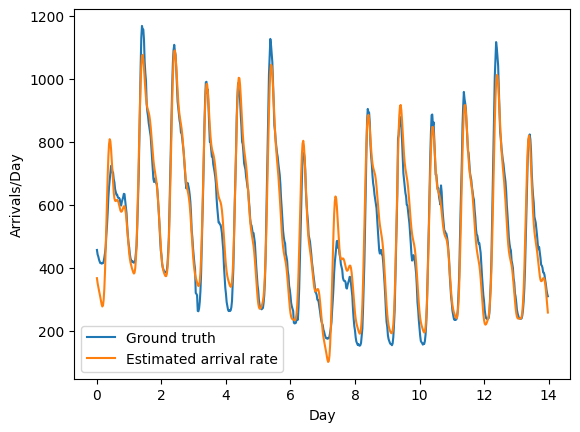

In [11]:
fig, ax = plt.subplots()
ground_truth[ground_truth["days"] < 14].plot(x = "days", y = ["true_rate", "sine-NHPP_fit"],
                                      ax=ax)
ax.legend(["Ground truth", "Estimated arrival rate"])
ax.set_xlabel("Day")
ax.set_ylabel("Arrivals/Day")